In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!ls

drive  sample_data


In [3]:
cd'/content/drive/MyDrive/Colab Notebooks/apple_plant'

/content/drive/MyDrive/Colab Notebooks/apple_plant


In [4]:

import tensorflow as tf
import os
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt
import pickle
import cv2
from imutils import paths
from os import listdir
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
from tensorflow.keras import models, layers

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D,Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=5

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"/content/drive/MyDrive/Colab Notebooks/apple_plant",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 6200 files belonging to 4 classes.


In [8]:
class_names=dataset.class_names
class_names

['Apple Apple scab',
 'Apple Black rot',
 'Apple Cedar apple rust',
 'Apple healthy']

(32, 256, 256, 3)
[3 0 1 0 3 0 2 0 3 3 2 3 1 3 3 2 1 2 0 0 3 0 1 3 1 3 2 1 3 3 2 3]


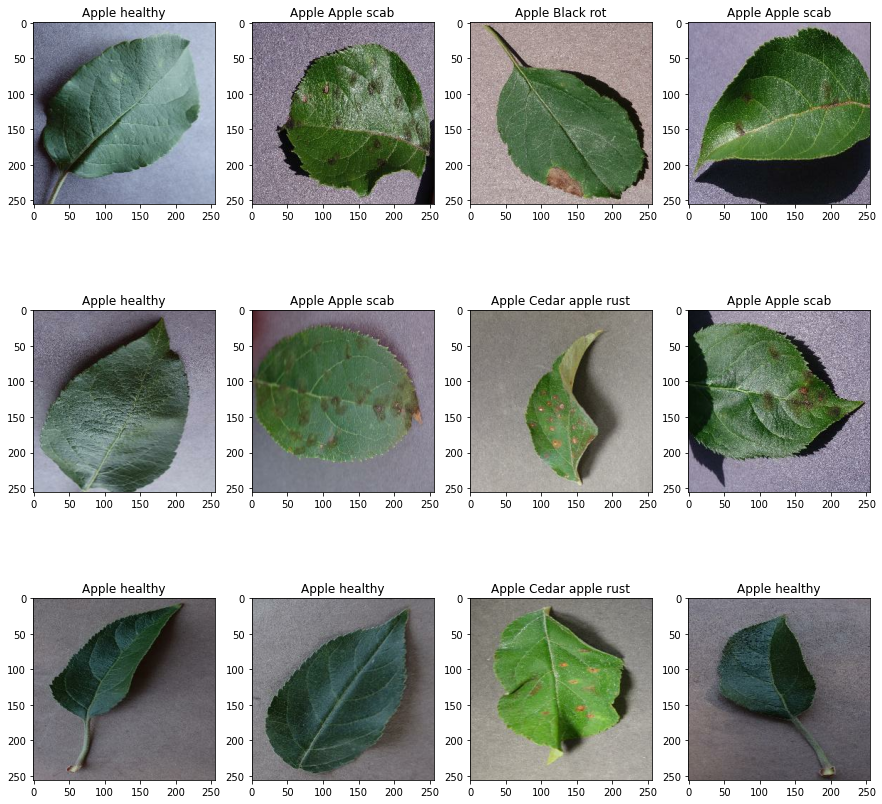

In [9]:
plt.figure(figsize=(15,15))
for image_batch,label_batch in dataset.take(1):
    for i in range (12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]] )
    print(image_batch.shape)
    print(label_batch.numpy())

In [10]:
len(dataset)

194

In [11]:
train_size=0.8
len(dataset)*train_size

155.20000000000002

In [12]:
train_ds=dataset.take(155)
len(train_ds)

155

In [13]:
test_ds=dataset.skip(155)
len(test_ds)

39

In [14]:
val_size=0.1
len(dataset)*val_size

19.400000000000002

In [15]:
val_ds=test_ds.take(19)
len(val_ds)

19

In [16]:
test_ds=test_ds.skip(19)
len(test_ds)

20

In [17]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [18]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [19]:
len(train_ds)

155

In [20]:
len(val_ds)

19

In [21]:
len(test_ds)

20

In [22]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [24]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2)
 
])

In [25]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [28]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [37]:
EPOCHS=30
history=model.fit(train_ds,epochs=EPOCHS,batch_size=BATCH_SIZE,
                  verbose=1,validation_data=val_ds)

Epoch 1/30
155/155 [==============================] - 46s 296ms/step - loss: 0.4201 - accuracy: 0.8439 - val_loss: 0.4961 - val_accuracy: 0.8141
Epoch 2/30
155/155 [==============================] - 47s 301ms/step - loss: 0.3638 - accuracy: 0.8689 - val_loss: 0.5154 - val_accuracy: 0.7993
Epoch 3/30
155/155 [==============================] - 46s 296ms/step - loss: 0.3644 - accuracy: 0.8700 - val_loss: 0.4376 - val_accuracy: 0.8339
Epoch 4/30
155/155 [==============================] - 46s 297ms/step - loss: 0.3803 - accuracy: 0.8657 - val_loss: 0.3894 - val_accuracy: 0.8536
Epoch 5/30
155/155 [==============================] - 46s 298ms/step - loss: 0.3026 - accuracy: 0.8912 - val_loss: 0.3400 - val_accuracy: 0.8668
Epoch 6/30
155/155 [==============================] - 47s 303ms/step - loss: 0.3027 - accuracy: 0.8889 - val_loss: 0.2747 - val_accuracy: 0.8931
Epoch 7/30
155/155 [==============================] - 46s 299ms/step - loss: 0.2716 - accuracy: 0.9111 - val_loss: 0.3245 - val_ac

In [38]:
scores = model.evaluate(test_ds)

20/20 [==============================] - 1s 34ms/step - loss: 0.0882 - accuracy: 0.9750


In [39]:
scores

[0.08817891776561737, 0.9750000238418579]

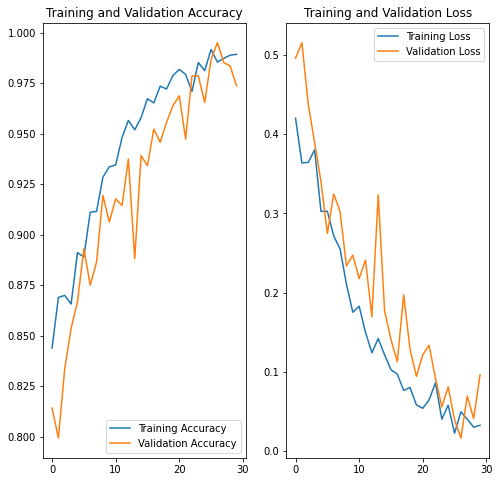

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Apple healthy
1/1 [==============================] - 0s 33ms/step
predicted label: Apple healthy


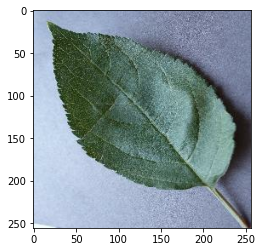

In [41]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [42]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 26ms/step


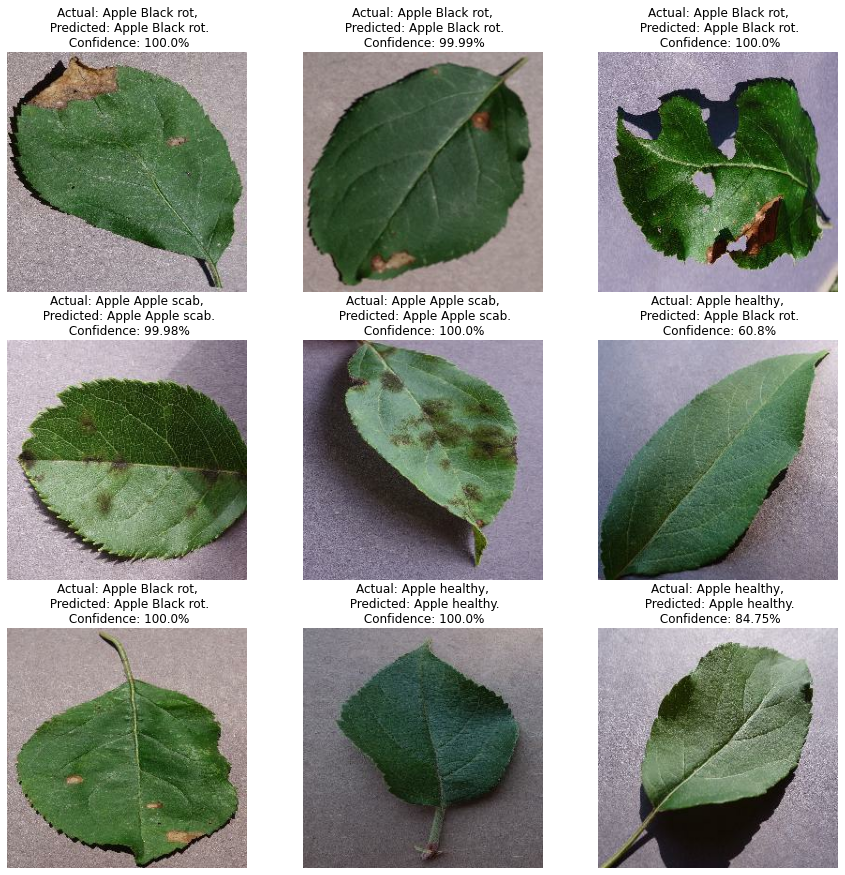

In [43]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [68]:
apple_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(apple_json)

In [69]:
model.save_weights("apple.h5")
print("Saved model to disk")

Saved model to disk


In [67]:
import pickle
with open('apple.pkl','wb' )as s:
    pickle.dump(model,s)

In [50]:
import time
t = time.time()

export_path_keras = "./{}.h5".format(int(t))
print(export_path_keras)

model.save(export_path_keras)

./1666682777.h5


In [51]:
!ls

 1666682777.h5	    'Apple Black rot'	      'Apple healthy'
'Apple Apple scab'  'Apple Cedar apple rust'


In [53]:
import tensorflow_hub as hub
reloaded = tf.keras.models.load_model(
  export_path_keras, 
  # `custom_objects` tells keras how to load a `hub.KerasLayer`
  custom_objects={'KerasLayer': hub.KerasLayer})

reloaded.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)       

In [54]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

1/1 [==============================] - 0s 108ms/step


In [55]:
(abs(result_batch - reloaded_result_batch)).max()

0.0

In [56]:
t = time.time()

export_path_sm = "./{}".format(int(t))
print(export_path_sm)

tf.saved_model.save(model, export_path_sm)

./1666683161


In [57]:
!ls {export_path_sm}

assets	saved_model.pb	variables


In [60]:
reloaded_sm = tf.saved_model.load(export_path_sm)

In [61]:

reload_sm_result_batch = reloaded_sm(image_batch, training=False).numpy()

In [62]:
(abs(result_batch - reload_sm_result_batch)).max()

0.0

In [64]:
!zip -r model.zip {export_path_sm}

  adding: 1666683161/ (stored 0%)
  adding: 1666683161/variables/ (stored 0%)
  adding: 1666683161/variables/variables.data-00000-of-00001 (deflated 10%)
  adding: 1666683161/variables/variables.index (deflated 71%)
  adding: 1666683161/assets/ (stored 0%)
  adding: 1666683161/saved_model.pb (deflated 89%)


In [65]:
!ls

 1666682777.h5	'Apple Apple scab'  'Apple Cedar apple rust'   model.zip
 1666683161	'Apple Black rot'   'Apple healthy'


In [66]:
try:
  from google.colab import files
  files.download('./model.zip')
except ImportError:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>